In [1]:
from __future__ import print_function
import pandas as pd
import tables as tb
import numpy as np
import time
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
import fitFunctions as fit
import tblFunctions as tbl
from HLObjects import Signal, Peak, PMap

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 11/11/2016 at 21:08:16.


# DATA CHECK

In [2]:
try:
    h5f.close()
except:
    pass

In [3]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/MC/Na_preprod.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/MC/Na_preprod.h5 (File) ''
Last modif.: 'Fri Nov 11 16:55:03 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(1000, 48000), shuffle, zlib(4)) ''
/BLR/pulse_on (EArray(1000, 48000), shuffle, zlib(4)) ''
/BLR/wait_over (EArray(1000, 48000), shuffle, zlib(4)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(3254,), zlib(4)) ''
/RD (Group) ''
/RD/pmtblr (EArray(1000, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtcwf (EArray(1000, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(1000, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(1000, 1792, 1200), shuffle, zlib(4)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''
/TWF (Group) ''
/TWF/PMT (Table(37607,), shuffle, zlib(4)) 'Store for PMTs TWF'
/TWF/SiPM (Table(168314,), shuffle, zlib(4)) 'Store for SiPM TWF'
/ZS (Group) ''

In [4]:
fee_tabl = h5f.root.MC.FEE

pmttwf   = h5f.root.TWF.PMT
sipmtwf  = h5f.root.TWF.SiPM

blrmau   = h5f.root.BLR.mau
blrpulse = h5f.root.BLR.pulse_on
blrwait  = h5f.root.BLR.wait_over

pmtcwf   = h5f.root.RD.pmtcwf
pmtblr   = h5f.root.RD.pmtblr

pmtrwf   = h5f.root.RD.pmtrwf
sipmrwf  = h5f.root.RD.sipmrwf

if '/ZS' in h5f:
    pmtzswf  = h5f.root.ZS.PMT
    blrzswf  = h5f.root.ZS.BLR
    sipmzswf = h5f.root.ZS.SiPM
    
pmtdf    = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
blrdf    = snf.read_data_sensors(h5f.root.Sensors.DataBLR)
sipmdf   = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

### PMT DF:

In [5]:
print(pmtdf)

    adc_to_pes  channel  coeff  noise_rms  sensorID           x           y
0    20.183636        0    0.0     0.7134         0  -23.941401   65.778503
1    18.615520       18    0.0     0.9578         1  -44.995098  -53.623100
2    18.576584        1    0.0     0.7090         2   68.936501  -12.155400
3    19.220570       19    0.0     0.7726         3   -0.000000  185.000000
4    19.197578       27    0.0     0.7348         4 -118.916000  141.718002
5    19.507175       26    0.0     0.7908         5 -182.188995   32.124901
6    19.716705        9    0.0     0.7045         6 -160.214996  -92.500000
7    17.901134        8    0.0     0.7362         7  -63.273701 -173.843002
8    19.128082       23    0.0     0.7339         8   63.273701 -173.843002
9    18.621046       22    0.0     0.7404         9  160.214996  -92.500000
10   19.379253        5    0.0     0.7299        10  182.188995   32.124901
11   19.443216        4    0.0     0.7217        11  118.916000  141.718002


### BLR DF:

In [6]:
print(blrdf)

    adc_to_pes  channel  coeff  noise_rms  sensorID           x           y
0    20.620396        0    0.0     0.7134         0  -23.941401   65.778503
1    19.038712       18    0.0     0.9578         1  -44.995098  -53.623100
2    19.010685        1    0.0     0.7090         2   68.936501  -12.155400
3    19.644022       19    0.0     0.7726         3   -0.000000  185.000000
4    19.615822       27    0.0     0.7348         4 -118.916000  141.718002
5    19.939041       26    0.0     0.7908         5 -182.188995   32.124901
6    20.142776        9    0.0     0.7045         6 -160.214996  -92.500000
7    18.324844        8    0.0     0.7362         7  -63.273701 -173.843002
8    19.553461       23    0.0     0.7339         8   63.273701 -173.843002
9    19.038948       22    0.0     0.7404         9  160.214996  -92.500000
10   19.803919        5    0.0     0.7299        10  182.188995   32.124901
11   19.860653        4    0.0     0.7217        11  118.916000  141.718002


In [7]:
print(sipmdf)

      adc_to_pes  channel  coeff  noise_rms  sensorID      x      y
0      16.697399     1000    1.0        0.0      1000 -235.0   45.0
1      15.939700     1001    1.0        0.0      1001 -235.0   55.0
2      17.644199     1002    1.0        0.0      1002 -235.0   65.0
3      16.433800     1003    1.0        0.0      1003 -235.0   75.0
4      17.346399     1004    1.0        0.0      1004 -235.0   85.0
5      17.094900     1005    1.0        0.0      1005 -235.0   95.0
6      15.670200     1006    1.0        0.0      1006 -235.0  105.0
7      15.809400     1007    1.0        0.0      1007 -235.0  115.0
8      16.476101     1008    1.0        0.0      1008 -225.0   45.0
9      16.568399     1009    1.0        0.0      1009 -225.0   55.0
10     16.748699     1010    1.0        0.0      1010 -225.0   65.0
11     15.997700     1011    1.0        0.0      1011 -225.0   75.0
12     16.100201     1012    1.0        0.0      1012 -225.0   85.0
13     15.957400     1013    1.0        0.0     

### FEE table:


In [8]:
for i in fee_tabl.colnames: print(i, '->', fee_tabl.col(i)[0])

offset -> 2500
ceiling -> 4096
pmt_gain -> 1.7e+06
V_gain -> 4.00544e-14
R -> 3.76512e-13
time_step -> 1.0
time_daq -> 25.0
freq_LPF -> 0.003
freq_HPF -> 1.09235e-05
LSB -> 4.88281e-10
volts_to_adc -> 0.000390625
noise_fee_rms -> 3e-10
noise_adc -> 0.768
C12 -> [  3.76347497e+16   3.88563243e+16   3.78680523e+16   3.88321222e+16
   3.93214779e+16   3.80664712e+16   3.85905732e+16   3.88081648e+16
   3.86540657e+16   3.93538705e+16   3.87198002e+16   3.93983363e+16]
AC -> [ 0.00165235  0.00163149  0.00163177  0.00162948  0.00158202  0.00159469
  0.00162493  0.00164257  0.00162681  0.00162087  0.00160063  0.00161127]
CR -> [ 20.18363571  18.61552048  18.57658386  19.22056961  19.19757843
  19.50717545  19.71670532  17.90113449  19.12808228  18.62104607
  19.37925339  19.44321632]
CB -> [ 20.62039566  19.03871155  19.01068497  19.64402199  19.61582184
  19.93904114  20.14277649  18.32484436  19.55346107  19.03894806
  19.80391884  19.86065292]


### Plot of the PMT TWF, RWF, BLR for event 0, PMT 0

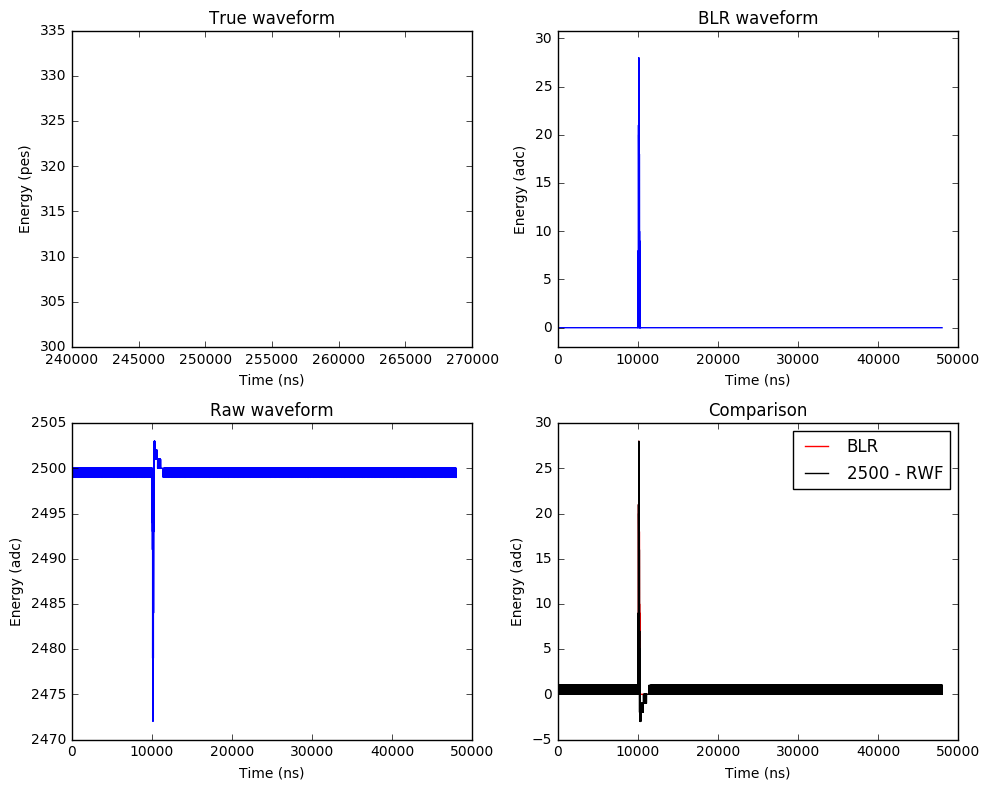

In [9]:
evt = 0
pmt = 0
Tt, Te = tbl.read_wf(pmttwf, evt, pmt)

fig, axes = plt.subplots(2, 2)
axes[0,0].plot(Tt,Te)
axes[0,1].plot(pmtblr[evt, pmt])
axes[0,1].set_ylim((-2, 1.1*pmtblr[evt, pmt].max()))
axes[1,0].plot(pmtrwf[evt, pmt])
axes[1,1].plot(pmtblr[evt, pmt], 'r', label='BLR')
axes[1,1].plot(2500-pmtrwf[evt, pmt], 'k', label='2500 - RWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (pes)');axes[0,0].set_title('True waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Raw waveform')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the SiPMs TWF, RWF for event 0, SiPM *max*

SiPM with greatest peak is at index 1741 with ID 28013.0


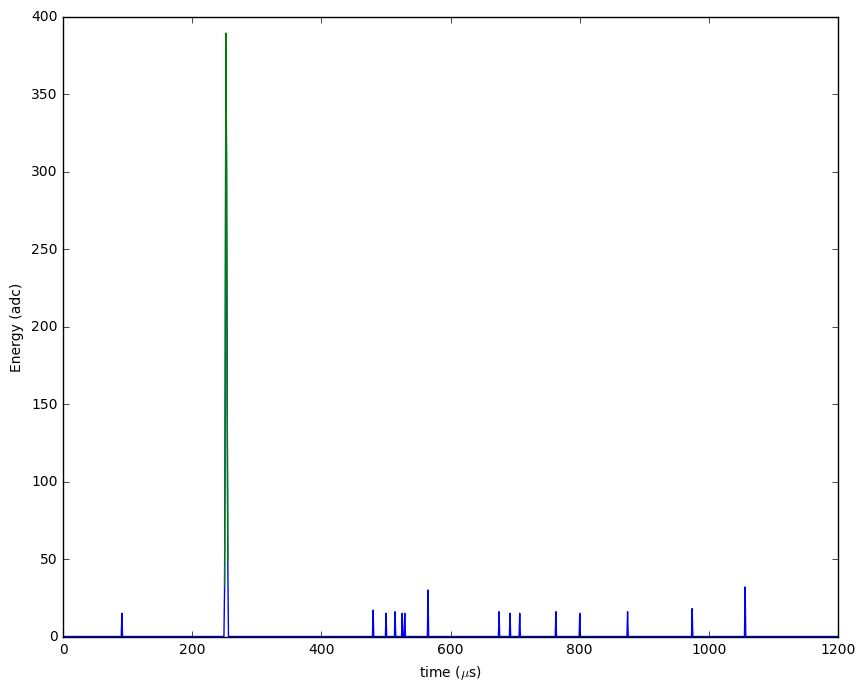

In [10]:
evt = 0
mpl.plot_best(sipmrwf, sipmtwf, sipmdf, evt)

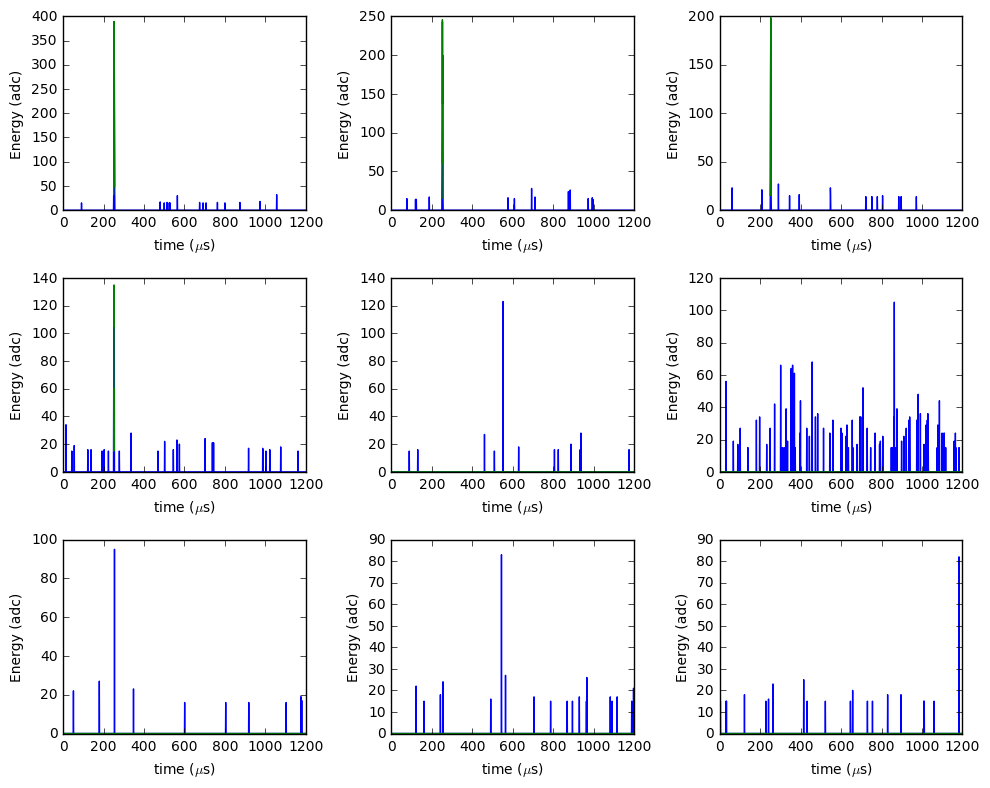

In [11]:
evt = 0
mpl.plot_best_group(sipmrwf, sipmtwf, sipmdf, evt, 9)

### Plot of the RWF, BLR and CWF for event 0 PMT 0:

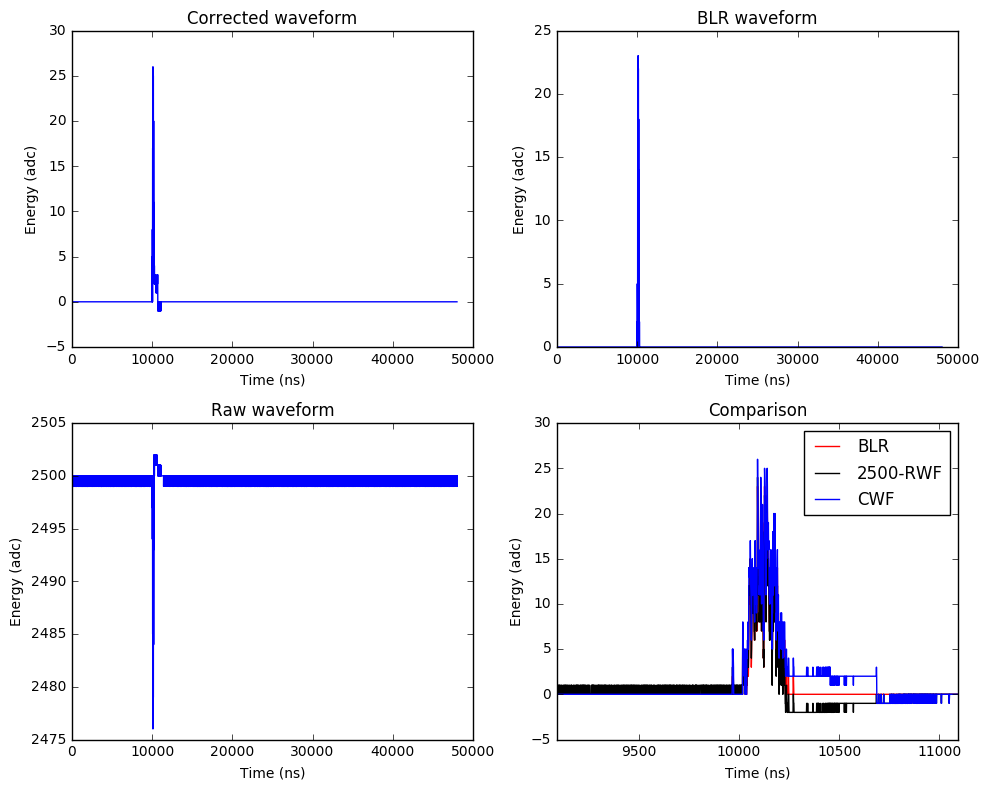

In [12]:
evt = 0
pmt = 1
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(pmtcwf[evt, pmt])
axes[0,1].plot(pmtblr[evt, pmt])
axes[1,0].plot(pmtrwf[evt, pmt])
axes[1,1].plot(pmtblr[evt, pmt], 'r', label='BLR')
axes[1,1].plot(2500-pmtrwf[evt, pmt], 'k', label='2500-RWF')
axes[1,1].plot(pmtcwf[evt, pmt], 'b', label='CWF')

peak, window = np.argmax(pmtcwf[evt, pmt]), 1000

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (adc)');axes[0,0].set_title('Corrected waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Raw waveform')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('Comparison')
axes[1,1].set_xlim((peak-window, peak+window))
axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the mau, pulse_on and wait_over variables for event 0

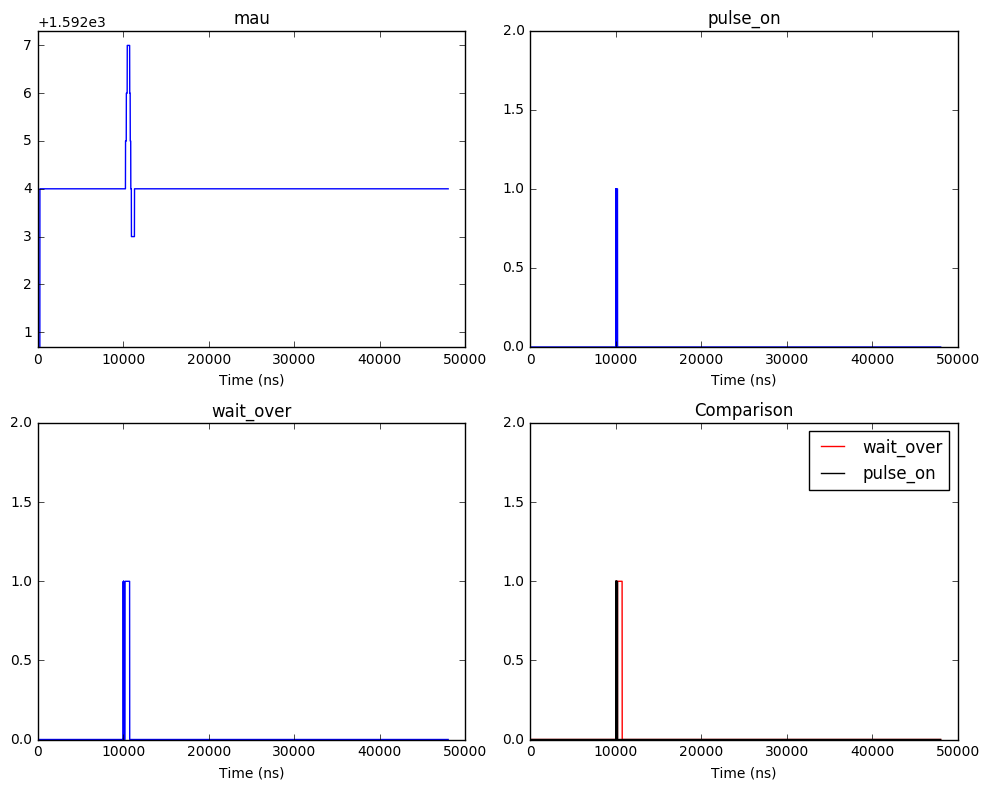

In [13]:
evt = 0
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(blrmau[evt])
axes[0,1].plot(blrpulse[evt])
axes[1,0].plot(blrwait[evt])
axes[1,1].plot(blrwait[evt], 'r', label='wait_over')
axes[1,1].plot(blrpulse[evt], 'k', label='pulse_on')

avemau, stdmau = np.bincount(blrmau[evt]).argmax(), np.std(blrmau[evt])
mauwindow = avemau - 0.05*stdmau, avemau + 0.05*stdmau,
axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylim(mauwindow);axes[0,0].set_title('mau')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylim((0,2));axes[0,1].set_title('pulse_on')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylim((0,2));axes[1,0].set_title('wait_over')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylim((0,2));axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the ZS CWF, and BLR for event 0 and PMT 0

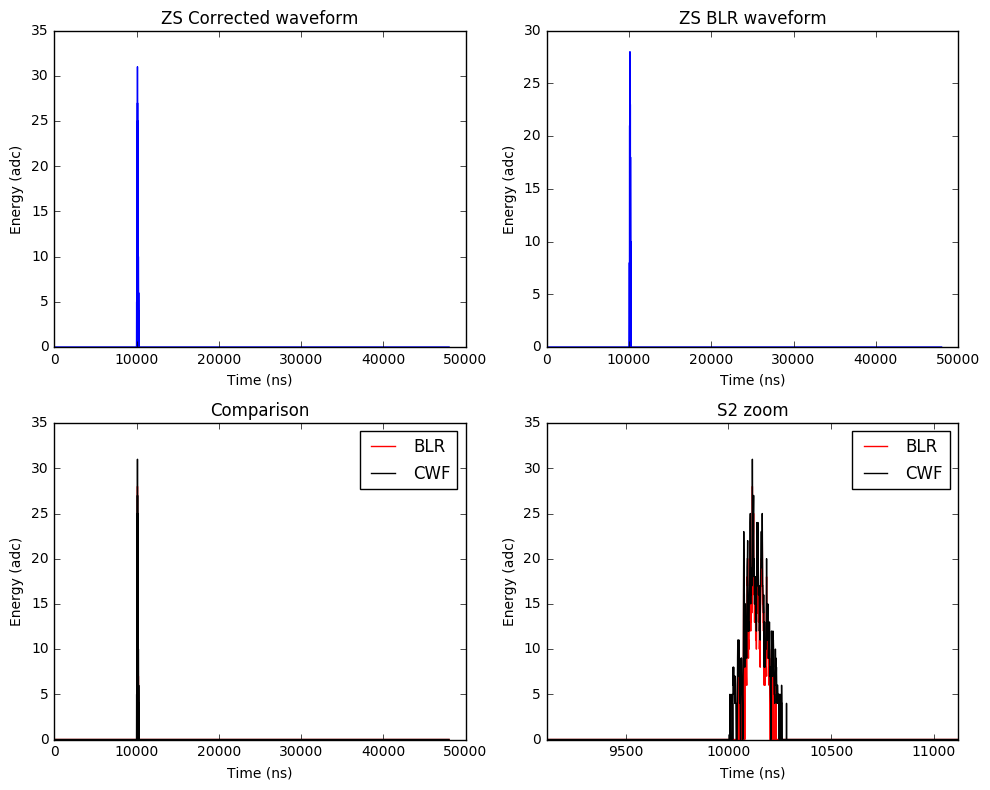

In [14]:
evt = 0
pmt = 0

fig, axes = plt.subplots(2, 2)
peak, window = np.argmax(pmtzswf[evt, 0]), 1000

axes[0,0].plot(pmtzswf[evt, pmt])
axes[0,1].plot(blrzswf[evt, pmt])
axes[1,0].plot(blrzswf[evt, pmt], 'r', label='BLR')
axes[1,0].plot(pmtzswf[evt, pmt], 'k', label='CWF')
axes[1,1].plot(blrzswf[evt, pmt], 'r', label='BLR')
axes[1,1].plot(pmtzswf[evt, pmt], 'k', label='CWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (adc)');axes[0,0].set_title('ZS Corrected waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('ZS BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Comparison')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('S2 zoom')
axes[1,1].set_xlim((peak-window, peak+window))

axes[1,0].legend()
axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the ZS SiPM WF for event 0:

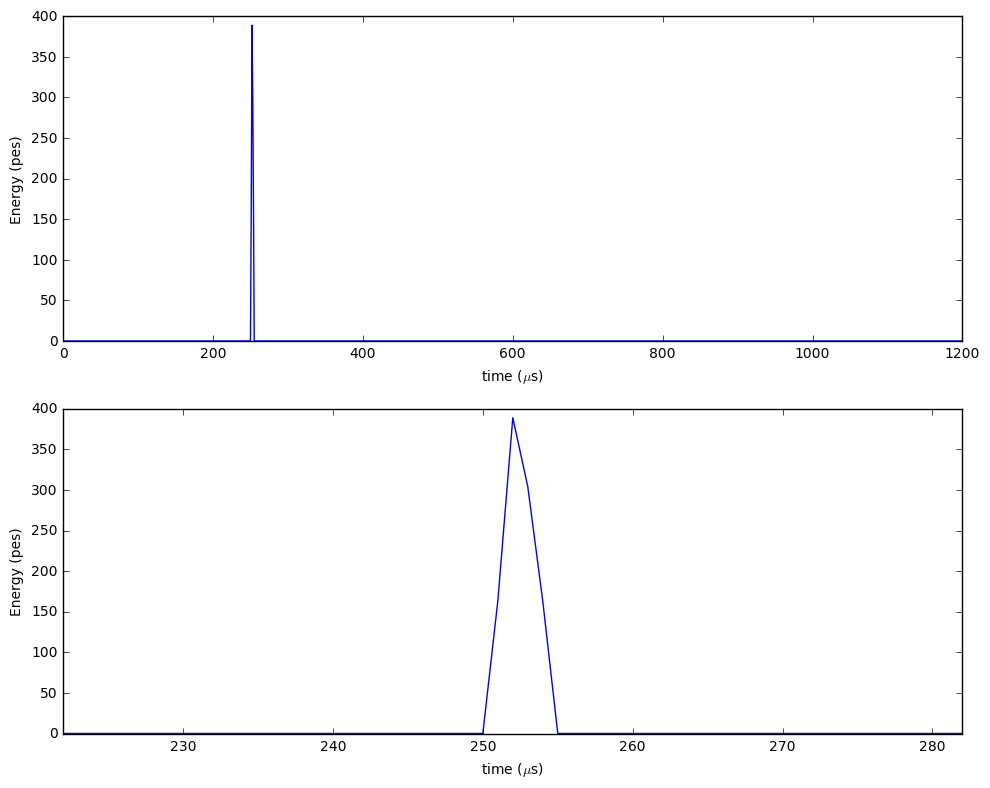

In [15]:
evt = 0

maxsipm = np.unravel_index(sipmzswf[evt].argmax(), sipmzswf[evt].shape)[0]
maxtime = np.argmax(sipmzswf[evt, maxsipm])
wfrange = maxtime - 30,  maxtime + 30

fig, ax = plt.subplots(2)
ax[0].plot(sipmzswf[evt, maxsipm])
ax[1].plot(sipmzswf[evt, maxsipm]);ax[1].set_xlim(wfrange)

ax[0].set_xlabel('time ($\mu$s)');ax[0].set_ylabel('Energy (pes)')
ax[1].set_xlabel('time ($\mu$s)');ax[1].set_ylabel('Energy (pes)')

fig.set_size_inches(10,8)
fig.tight_layout()

## Statistical studies about energy

In [16]:
nevts, npmt, pmtwl = pmtrwf.shape
Etrue = np.empty(nevts)
Eblr = np.empty(nevts)
Ecorr = np.empty(nevts)

adc_to_pes_cor = 1.0/pmtdf.adc_to_pes[:].reshape(npmt, 1)
adc_to_pes_blr = 1.0/blrdf.adc_to_pes[:].reshape(npmt, 1)

for i in range(nevts):
    Ecorr[i] = np.sum(pmtzswf[i] * adc_to_pes_cor)
    Eblr[i] = np.sum(blrzswf[i] * adc_to_pes_blr)
    Etrue[i] = tbl.read_wf_table(pmttwf,i).sum().sum(axis=1).ene_pes

selection = (Ecorr>0) & (Ecorr<np.mean(Ecorr)+5*np.std(Ecorr))
Ecorr = Ecorr[selection]
Eblr = Eblr[selection]
Etrue = Etrue[selection]

Ratio_CT = Ecorr/Etrue
Ratio_CB = Ecorr/Eblr
Ratio_BT = Eblr/Etrue

### Comparison between true and corrected

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

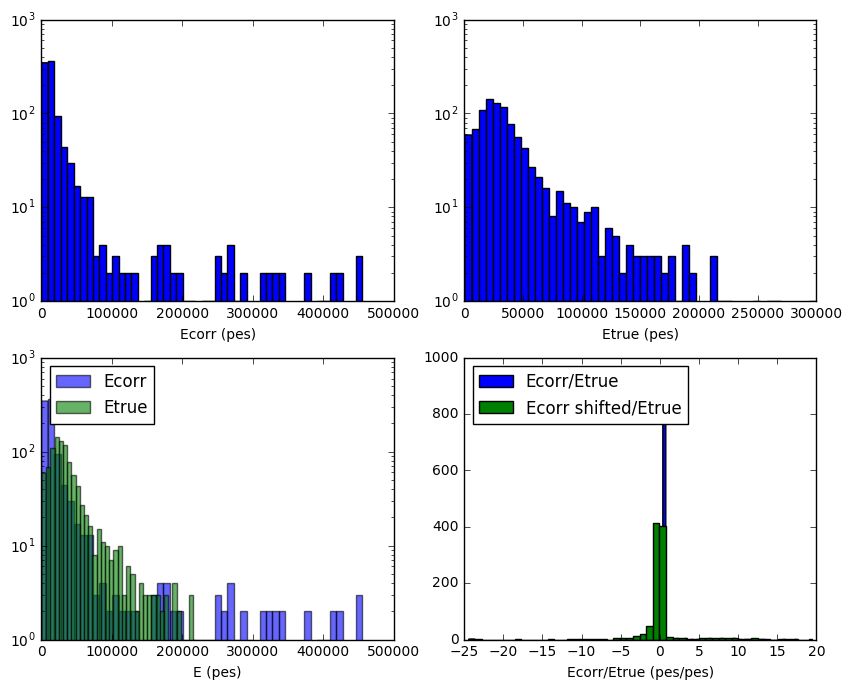

In [21]:
nbins = 50

vals, cov = fit.fit_poly(Etrue, Ecorr, (100., 1.))
c0, c1 = vals

R = Ratio_CT
R_shift = (Ecorr-c0)/Etrue

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

hcorr  = axes[0,0].hist(Ecorr, nbins)
htrue  = axes[0,1].hist(Etrue, nbins)
hcorr  = axes[1,0].hist(Ecorr, nbins, label='Ecorr', alpha=0.5)
htrue  = axes[1,0].hist(Etrue, nbins, label='Etrue', alpha=0.5)

axes[1,0].legend(loc='upper left')
hR = axes[1,1].hist(R, nbins, label='Ecorr/Etrue')
hR_shift= axes[1,1].hist(R_shift, nbins, label='Ecorr shifted/Etrue', color='g')
axes[1,1].legend(loc='upper left')

axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
axes[1,0].set_yscale('log')

axes[0,0].set_xlabel('Ecorr (pes)')
axes[0,1].set_xlabel('Etrue (pes)')
axes[1,0].set_xlabel('E (pes)')
axes[1,1].set_xlabel('Ecorr/Etrue (pes/pes)')

xlim = axes[1,1].get_xlim()
ylim = axes[1,1].get_ylim()

x, y = hR[1][:-1], hR[0]
vals, cov = fit.fit_gauss(x, y, (np.max(y), np.mean(x), np.std(x) * 0.1))
amp, mu, sigma = vals
y = fit.build_gauss(*vals)(x)
axes[1,1].plot(x, y, 'k-', linewidth=2)

x = xlim[0] + 0.8*(xlim[1]-xlim[0])
y = ylim[0] + 0.4*(ylim[1]-ylim[0])
axes[1,1].text(x, y, '$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu, sigma), fontsize=15, color='k')


x, y = hR_shift[1][:-1], hR_shift[0]
vals, cov = fit.fit_gauss(x, y, (np.max(y), np.mean(x), np.std(x) * 0.1))
amp, mu, sigma = vals
y = fit.build_gauss(*vals)(x)
axes[1,1].plot(x, y, 'm-', linewidth=2)

x = xlim[0] + 0.8*(xlim[1]-xlim[0])
y = ylim[0] + 0.6*(ylim[1]-ylim[0])
axes[1,1].text(x, y, '$\mu$-sh = {:.4f}\n$\sigma$-sh = {:.4f}'.format(mu, sigma), fontsize=15, color='m')

plt.tight_layout()


### Statistical studies about energy: comparison between BLR and corrected

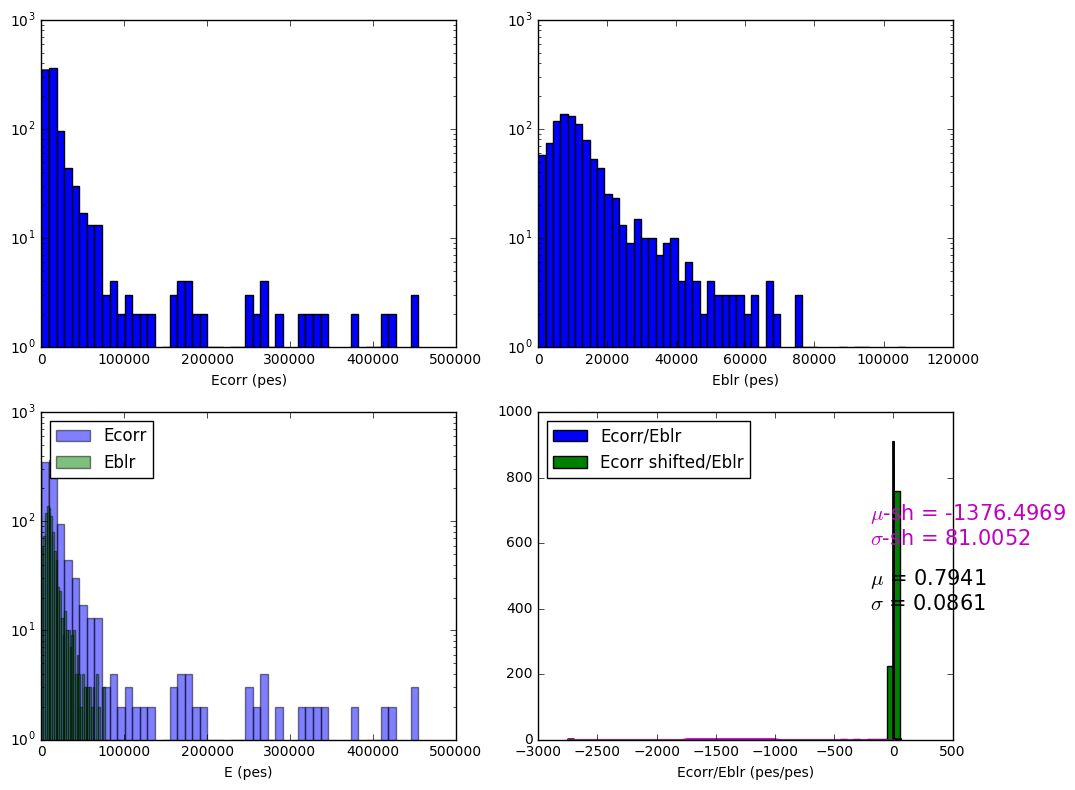

In [22]:
nbins = 50

vals, cov = fit.fit_poly(Eblr, Ecorr, (100.,1.))
c0, c1 = vals

R = Ratio_CB
R_shift = (Ecorr-c0)/Eblr

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

hcorr = axes[0,0].hist(Ecorr, nbins)
hblr = axes[0,1].hist(Eblr, nbins)
hcorr = axes[1,0].hist(Ecorr, nbins, label='Ecorr', alpha=0.5)
hblr = axes[1,0].hist(Eblr, nbins, label='Eblr', alpha=0.5)

axes[1,0].legend(loc='upper left')
hR = axes[1,1].hist(R, nbins, label='Ecorr/Eblr')
hR_shift = axes[1,1].hist(R_shift, nbins, label='Ecorr shifted/Eblr', color='g')
axes[1,1].legend(loc='upper left')

axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
axes[1,0].set_yscale('log')

axes[0,0].set_xlabel('Ecorr (pes)')
axes[0,1].set_xlabel('Eblr (pes)')
axes[1,0].set_xlabel('E (pes)')
axes[1,1].set_xlabel('Ecorr/Eblr (pes/pes)')

xlim = axes[1,1].get_xlim()
ylim = axes[1,1].get_ylim()

x, y = hR[1][:-1], hR[0]
vals, cov = fit.fit_gauss(x, y, (np.max(y), np.mean(x), np.std(x) * 0.1))
amp, mu, sigma = vals
y = fit.build_gauss(*vals)(x)
axes[1,1].plot(x, y, 'k-', linewidth=2)

x = xlim[0] + 0.8*(xlim[1]-xlim[0])
y = ylim[0] + 0.4*(ylim[1]-ylim[0])
axes[1,1].text(x, y, '$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu,sigma), fontsize=15, color='k')


x, y = hR_shift[1][:-1], hR_shift[0]
vals, cov = fit.fit_gauss(x, y,(np.max(y), np.mean(x), np.std(x) * 0.1))
amp, mu, sigma = vals
y = fit.build_gauss(*vals)(x)
axes[1,1].plot(x, y, 'm-', linewidth=2)

x = xlim[0] + 0.8*(xlim[1]-xlim[0])
y = ylim[0] + 0.6*(ylim[1]-ylim[0])
axes[1,1].text(x, y, '$\mu$-sh = {:.4f}\n$\sigma$-sh = {:.4f}'.format(mu, sigma), fontsize=15, color='m')

plt.tight_layout()

# PMAPS

In [23]:
h5maps = tb.open_file("/Users/Gonzalo/github/IC/data/MC/Na_preprod_pmaps.h5")

In [24]:
print(h5maps)

/Users/Gonzalo/github/IC/data/MC/Na_preprod_pmaps.h5 (File) ''
Last modif.: 'Fri Nov 11 17:23:01 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(3254,), zlib(4)) ''
/PMAPS (Group) ''
/PMAPS/PMaps (Table(20439,), shuffle, zlib(4)) 'Store for PMaps'
/PMAPS/PMapsBLR (Table(16008,), shuffle, zlib(4)) 'Store for PMaps made with BLR'
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''



In [25]:
pmaps_ = h5maps.root.PMAPS.PMaps
blrs_ = h5maps.root.PMAPS.PMapsBLR

In [26]:
nevt = len(set(pmaps_.cols.event))
pmaps = np.empty(nevt, dtype=object)
npeaks = np.empty(nevt)
t0s = np.empty(nevt)
nS1 = np.empty(nevt)
nS2 = np.empty(nevt)
nUN = np.empty(nevt)
for i in range(nevt):
    pmaps[i] = pmap = tbl.read_pmap(pmaps_, i)
    npeaks[i] = len(pmap.peaks)
    t0s[i] = pmap.t0
    sigs = [p.signal for p in pmap.peaks]
    nS1[i] = sigs.count(Signal.S1)
    nS2[i] = sigs.count(Signal.S2)
    nUN[i] = sigs.count(Signal.UNKNOWN)

## Histogram of the number of peaks

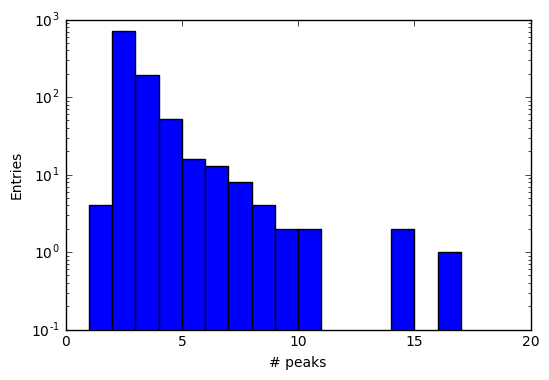

In [38]:
h = plt.hist(npeaks, 20, range=(0,20))
plt.xlabel("# peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## Histogram of the number of S1 peaks per event

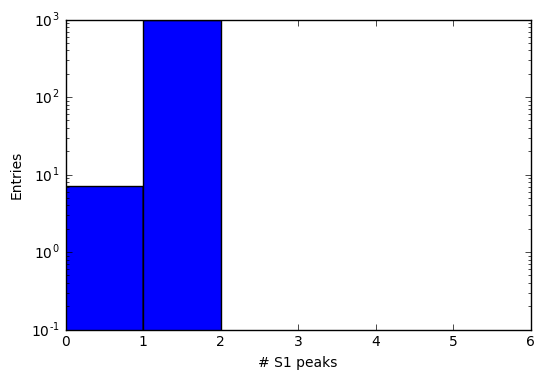

In [39]:
h = plt.hist(nS1,6,range=(0,6))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## Histogram of the number of S2 peaks per event

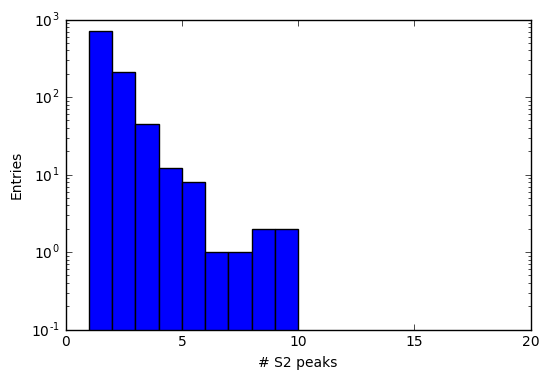

In [42]:
h = plt.hist(nS2, 20, range=(0,20))
plt.xlabel("# S2 peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

## Histogram of the number of unclassified peaks per event

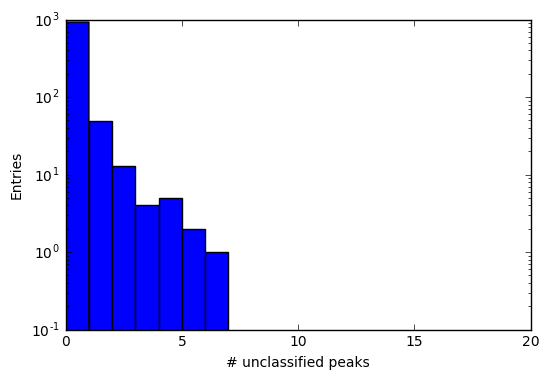

In [45]:
h = plt.hist(nUN, 20, range=(0,20))
plt.xlabel("# unclassified peaks")
plt.ylabel("Entries")
plt.ylim((1e-1,nevt))
plt.yscale("log")

**Stats**
1. 0.7% of the events have no S1
2. 0.0% of the events have more than one S1
3. 28.0% of the events have more than one S2
4. 7.4% of the events have unclassified (extra) peaks


## Histogram of the t0 (not yet set)

(0.1, 1000)

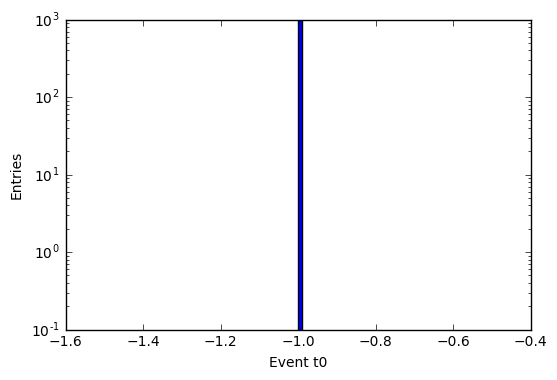

In [48]:
plt.hist(t0s, 100)
plt.xlabel("Event t0")
plt.ylabel("Entries")
plt.yscale("log")
plt.ylim((1e-1,nevt))

## A plot of one PMap with several peaks

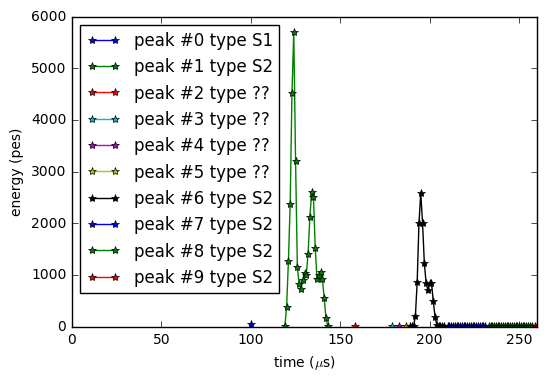

In [56]:
mpl.plot_pmap(pmaps[81])

## Histogram of the number of non-zero 25ns-samples in the same peak

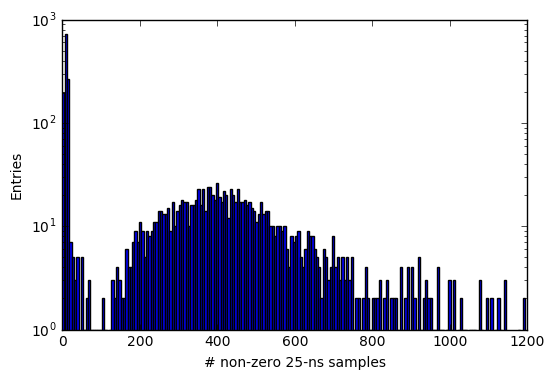

In [57]:
data = [pk.tothrs.sum() for pmap in pmaps for pk in pmap.peaks]
h = plt.hist(np.array(data).flatten(), 200, range=(0,1200))
plt.xlabel("# non-zero 25-ns samples")
plt.ylabel("Entries")
plt.yscale("log")

## Histogram of the width of the peaks

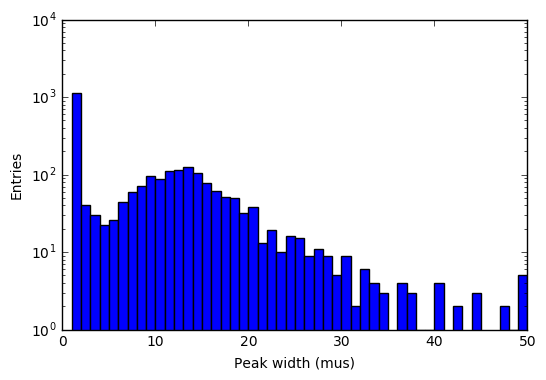

In [59]:
data = [pk.width for pmap in pmaps for pk in pmap.peaks]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.xlabel("Peak width (mus)")
plt.ylabel("Entries")
plt.yscale('log')

## Scatter plot of the number of non-zero samples vs width of the peaks

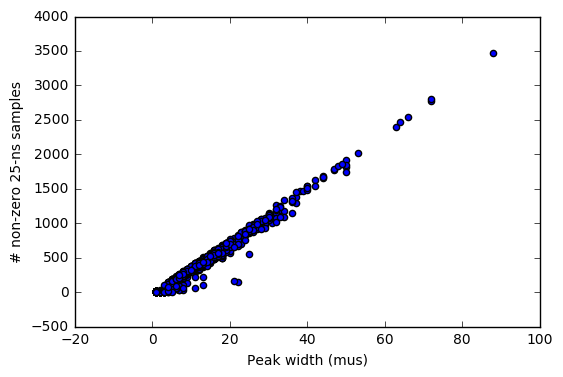

In [60]:
width, tot = zip(*[(pk.width, pk.tothrs.sum()) for pmap in pmaps for pk in pmap.peaks])
h = plt.scatter(width, tot)
plt.xlabel("Peak width (mus)")
plt.ylabel("# non-zero 25-ns samples")

## Histogram of S2 peaks integral

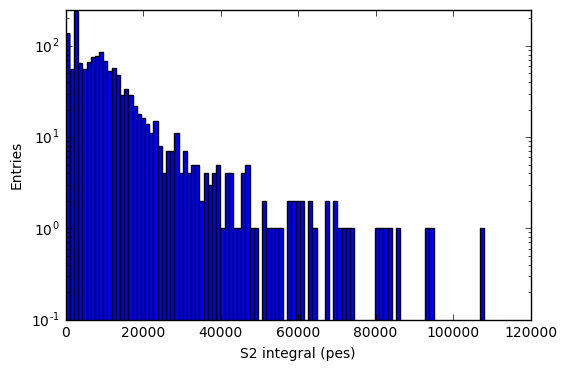

In [61]:
data = [pk.cathode_integral for pmap in pmaps for pk in pmap.peaks if pk.signal == Signal.S2]
h = plt.hist(np.array(data).flatten(), 100)
plt.ylim(1e-1, plt.ylim()[1])
plt.xlabel("S2 integral (pes)")
plt.ylabel("Entries")
plt.yscale('log')